# Introduction

This notebook guides through calibration function development using published data (S. De Vito et al., Sensors and Actuators B: Chemical, Volume 129, Issue 2).

In [2]:
# Load libriaries.
import pandas as pd
import numpy as np
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
import matplotlib.pyplot as plt
plt.rcParams["lines.linewidth"] = 1.0
plt.rcParams["font.size"] = 6.0
plt.rcParams["axes.titlesize"] = 6.0

# Additional Functions

Define some helper functions.

In [3]:
# Define helper functions.
scaler = StandardScaler() # Define standard scaler instance.
detector = IsolationForest(n_estimators=1000, behaviour="deprecated", contamination="auto", random_state=0) # Define outlier detector instance.
lin_reg = LinearRegression() # Define linear regression instance.

# Preprocessing
Data is scaled before analysis. In particular, standard scaling provides better results with respect to R2 score and explained variance compared with unscaled analysis. No imputation is performed.

In [4]:
# Load data and keep only first six months.
data = pd.read_excel("data.xlsx")
data = data[data["Date"] <= "2004-09-10"]

# Visualize data summary.
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,3447.000000,4275.000000,914.000000,4275.000000,4275.000000,3525.000000,4275.000000,3522.000000,4275.000000,4275.000000,4275.000000,4275.000000,4275.000000
mean,1.918422,1077.334113,218.811816,9.850661,937.848090,126.051348,897.271150,94.706133,1617.936394,944.460370,23.451201,42.485045,1.153040
std,1.206673,200.344215,204.459921,6.566329,240.489984,83.970746,228.686816,36.637686,255.788785,343.175279,7.843419,15.985736,0.343338
min,0.100000,708.000000,7.000000,0.464418,437.000000,2.000000,387.500000,5.000000,955.000000,263.000000,6.100000,9.175000,0.375444
25%,1.000000,932.250000,67.000000,4.843458,755.500000,63.000000,735.875000,67.000000,1441.750000,692.875000,17.300000,29.500000,0.904255
50%,1.700000,1047.500000,150.000000,8.499723,919.500000,108.000000,860.000000,94.000000,1587.000000,896.500000,23.450000,42.500000,1.096318
75%,2.500000,1184.250000,297.000000,13.385657,1096.500000,168.000000,1022.750000,119.000000,1752.625000,1150.625000,28.600000,54.000000,1.366492
max,8.100000,2039.750000,1189.000000,40.260061,1776.250000,631.000000,1940.750000,233.000000,2746.000000,2474.750000,44.600000,85.150002,2.180639


In [5]:
# Select columns and remove rows with missing values.
columns = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH", "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
data = data[columns].dropna(axis=0)

# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(data)

# Optional: Impute missing values.
# X_t = imputer.fit_transform(X_t)

# Remove outliers.
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]

# Restore frame.
dataset = pd.DataFrame(X_t, columns=columns)

# Select labels for inputs and outputs.
inputs = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]
outputs = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

# Data Handling
First, a data pipline is to be defined.

In [6]:
# Define some hyperparameters.
n_epochs = 50
n_samples = dataset.shape[0]
batch_size = np.floor(n_samples/10)
buffer_size = n_samples

# Define training and test data sizes.
n_train = int(0.7*dataset.shape[0])

# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values)) # Define input/output data.
data = data.shuffle(n_samples, reshuffle_each_iteration=True) # Shuffle.

# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1).repeat(n_epochs)

# Training
A deterministic neural network with two layers and Dropout is used as machine learning algorithm.

In [7]:
# Define Callbacks.
checkpoint = tfk.callbacks.ModelCheckpoint(filepath="model.h5", save_best_only=True, verbose=0) # Define checkpoint.
earlystopping = tfk.callbacks.EarlyStopping(monitor="loss", patience=3) # Define early stopping.
tensorboard = tfk.callbacks.TensorBoard(log_dir="./logs", histogram_freq=0, write_graph=True, write_images=True) # Define TensorBoard.

# Define model instance.
model = tfk.Sequential([
    tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"), # Input layer.
    tfk.layers.Dropout(0.0, name="dropout_1"),
    tfk.layers.Dense(10, activation="relu", name="dense_1"), # First layer with ten nodes and non-linear activation.
    tfk.layers.Dropout(0.0, name="dropout_2"),
    tfk.layers.Dense(len(outputs), activation="linear", name="output") # Output layer.
], name="model")

# Compile model.
model.compile(optimizer="adam", loss="mse") # MSE as loss function and ADAM optimizer.

# Run training session.
model.fit(data_train, epochs=n_epochs, callbacks=[checkpoint, earlystopping, tensorboard], validation_data=data_test, verbose=False)

# Describe model.
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                70        
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 44        
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________


# Evaluation
Evaluate losses, coefficient of determinations, and slope.

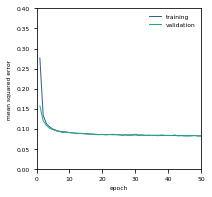

In [8]:
# Plot the training session.
fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
plt.xlim(0, np.round(len(model.history.epoch)+4,-1))
plt.ylim(0.0, 0.4)
plt.xlabel("epoch")
plt.ylabel("mean squared error")
plt.plot(list(map(lambda x: x + 1, model.history.epoch)), model.history.history["loss"], label="training", color=plt.cm.viridis(0.3))
plt.plot(list(map(lambda x: x + 1, model.history.epoch)), model.history.history["val_loss"], label="validation", color=plt.cm.viridis(0.6))
plt.legend(frameon=False, loc=0)
plt.savefig('./figures/metrics',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [31]:
# Predict.
samples = int(0.3*dataset.shape[0])
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
Y_true, Y_pred = np.empty(shape=(samples,len(outputs))), np.empty(shape=(samples,len(outputs)))
for i in range(samples):
    features, labels = test_iterator.get_next()
    Y_true[i] = labels.numpy()
    Y_pred[i] = model.predict(features)

In [32]:
# Calculate some metrics.
exp = explained_variance_score(Y_true, Y_pred)
r2 = r2_score(Y_true, Y_pred)
mse = mean_squared_error(Y_true, Y_pred)
print("Explained variance is", np.round(exp, 2), ", R2 score is", np.round(r2, 2), ", and MSE is", np.round(mse, 2), ".")

Explained variance is 0.86 , R2 score is 0.86 , and MSE is 0.09 .


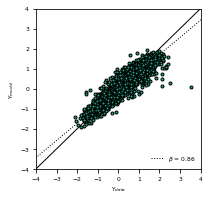

In [33]:
# Determine slope.
slope = lin_reg.fit(Y_true.flatten().reshape(-1, 1), Y_pred.flatten().reshape(-1, 1))

# Perform predictions.
Y_syn = np.linspace(-10, 10, 10)
Y_syn_p = slope.predict(Y_syn.reshape(-1, 1))

# Plot predictions vs. true values.
fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Y$_{data}$")
ax.set_ylabel(r"Y$_{model}$")
ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-4.0, 4.0)
ax.plot(Y_syn, Y_syn_p, ":", color="k", label=r"$\beta$ = "+str(np.round(slope.coef_[0][0],2)))
ax.plot([-10,10], [-10,10], "-", color="k")
ax.plot(Y_true, Y_pred, color=plt.cm.viridis(0.6), marker=".", alpha=1.0, mec='k', linestyle="")
plt.legend(frameon=False, loc=4)
plt.savefig('./figures/congruency',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()